# Data Processing Of MCMC Simulation Data from Binary Alloy

The main objective of this notebook is to document and illustrate all data analysis for determination of critical temperatures and graphics generation for my Theoretical Investigations Project. I have already determined mean field critical curves for the BEG model, and in this notebook I set out to:

1. Produce Order Parameter profiles for several values of vancy and atom chemical potential difference.
1. Compute critical temperatures for several Lattice sizes and vacancy - atom chemical potential difference.
1. Use finite size scaling to determine a set of critical points in $h - T$ phase space projection.

**Note:** During the development of this phase of the project, I updated my PC to MacOs Big Sur. This had the unexpected effect of slowing python scripts. As a result, I resorted to using an Azure server with 2 vcpus and 8GB of RAM. Most of the data used in this project was generated on that server. It took about 2 weeks of computation to generate order parameter data for all lattice sizes. I had parallelised routines to fasten computation of magnetisation profiles, they were pointless on my Azure server since it has only 2 vcpus.

In [121]:
# Do you have a latex distro on your PC?
latex_in_my_pc = True

In [117]:
# Imports for clarity
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
from scipy.optimize import curve_fit
from scipy.stats import linregress
import pandas as pd
# Import of the module I wrote for MCMC Simulation
import IsingModel as Alloy
if latex_in_my_pc:
    plt.style.use('FigureStyle/PaperStyle.mplstyle')

## Order Parameter Profiles for Different Lattice Sizes and Chemical Potential Differences

Remember that the sampled Hamiltonian corresponds to a ferromagnetic BEG Model, on a centered rectangular lattice, with a non-zero quadrtupolar anisotropy term, in the presence of an staggered external magnetic field:

$$H = -\frac{J}{2} \sum\limits_{\langle i_{A_2}, j_{B_2}\rangle} S_{i_{A_2}} S_{j_{B_2}} + \mu\sum\limits_{i} S_i^2 + h\sum\limits_{i_B} S_{i_B} - h\sum\limits_{i_A} S_{i_A}$$

I used conventional MCMC (Markov Chain Monte Carlo) to sample the Gibbs-Boltzman distribution corresponding to this system. Just to remember, the system under study is a bipartite, substitutional, non-stoichiometric, binary alloy. I used MCMC techniques to compute equilibrium values of order parameter:

$$m = \langle S_{i_{A_2}} \rangle + \langle S_{i_{B_2}}\rangle$$

I know that order parameter profile depends not only on temperature, but also on lattice size. Therefore, I computed several datasets corresponding to different values of $\mu$, $h$, temperature ($T$) and lattice size ($L$). I normalised unit energies so that $J = 1$, and units of entropy so that Boltzman's constant, $k_B = 1$.

Each dataset corresponds to magnetisation for 30 equaly spaced temperatures between $T_{\text{min}}=0.05$ and $T_{\text{max}} = 3.5$. I computed magnetisation profiles for values $\mu = 0.0, -1.7$ and $h = 0.0, 0.1, 0.3, 0.5$. Datasets correpsonds to lattice sizes $L = 8, 16, 32, 55$. The dataset files are saved as csv, and the names are **AltL_Mags_mu_h.csv**, in accordance to the following convention:

| Index | $L$ | $\mu$ | $h$ |
|:-----:|:---:|:-----:|:---:|
|  $0$  | $55$|  $0$  |$0.0$|
|  $1$  | $8$ | $-1.7$|$0.1$|
|  $2$  | $16$|   -   |$0.3$|
|  $3$  | $32$|   -   |$0.5$|
|  $4$  | $11$|   -   |  -  |

**Important:** MCMC Simulations consisted on 15000 steps, with 5000 spare steps.

In [125]:
# Define keys for plotting
Lkey = [55,8,16,32,11]
Mukey = [0.0,-1.7]
hkey = [0.0,0.1,0.3,0.5]

In [189]:
# Read all data files corresponding to indexes following table above and store data for plotting
Muidx = '1'
hidx = '3'
save_ = True

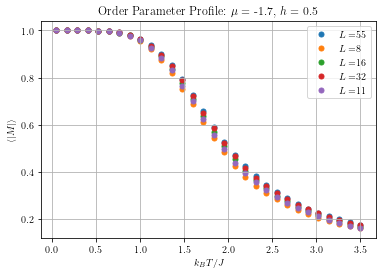

In [190]:
for i in range(5):
    # Reading with pandas
    filepath = 'Data/Alt'+str(i)+'_'+'Mags_'+Muidx+'_'+hidx+'.csv'
    dataset = pd.read_csv(filepath)
    # Generate scatter plot
    plt.scatter(dataset['Temps'],dataset['Mags'],label=r'$L=$'+str(Lkey[i]))
plt.xlabel(r'$k_BT/J$')
plt.ylabel(r'$\langle |M| \rangle$')
plt.title(r'Order Parameter Profile: '+r'$\mu=$ '+str(Mukey[int(Muidx)])+r', $h=$ '+str(hkey[int(hidx)]))
plt.legend()
if save_:
    plt.savefig('Figures/'+'MagsProf_'+Muidx+'_'+hidx+'.pdf')
    plt.savefig('Figures/'+'MagsProf_'+Muidx+'_'+hidx+'.png')
plt.show()

In the above cell, a quick overview of the datasets simulated via MCMC can be obtained. A quite unexpected magnetisation profile was obtained when $h > 0$. Although the curve seems to have a critical point, lattice size does not seem to affect the equilibrium magnetisation. This is rather weird, since at a critical point, correlation length diverges, and the finitness of the system should affect the magnetisation profile. As is evident from the Hamiltonian, the value of $\mu$, which is related to vacancy concentration, is not resposible for this behavior. The presence of a non-zero staggered field causes a a non-zero order parameter even at high temperatures. This is readily seen from a magnetic interpretation of the interaction Hamiltonian. Also, remembering that the order parameter is also related to atom concentration difference, this can be intuited.

**Conjecture:** It might be possible that for high staggered field magnitude, this phenomenon competes strongly with the inherent lattice site correlation, thus diminishing significantly the dependence of the order parameter profile with lattice size.

## Computation of critical temperatures

I compute critical temperatures by interpolating order parameter data, and computing the inflection point. Although my simulations showed rather strange profiles for non stoichiometric alloys, the still present an inflection point, which I will use to estimate critical temperature. I will, however, use finte size scaling to determine the actual critical temperature of a stoichiometric binary alloy for the values of $\mu$ considered.

### Data Interoplation

I chose the function

$$f(x) = A \tanh(C-Dx)+B$$

To interpolate the order parameter data. Although this function might not be the best for this purpose, it allows easy estimation of critical temperature as

$$T_C(L) = \frac{C}{D}$$

In the next cell, I plot inverse critical temperature as funciton of inverse lattice size following Ibarra and others' work.

**Important:** Spin-1 Ising Models do not have a closed form for order parameter as function of temperature, like Onsager's solution to the Spin-1/2 Ising model on 2 dimensions. Ibarra proposes a fit of the type

$$m = \bigg[A - B \bigg(\sinh\bigg(\frac{2}{T}\bigg)\bigg)^{-4}\bigg]^C$$

But this is valid only for temperatures below $T_C$, which I want to find. Therefore, it is not a very good option for fitting the data.

In [20]:
# Interpolation Function
def magsFit(x,A,B,C,D):
    return A*np.tanh(C-D*x)+B

In [151]:
# Indexes for reading data
Muidx = '0'
hidx = '3'
Lidx = '3'
# Tag to tell program if saving plots
save_ = False

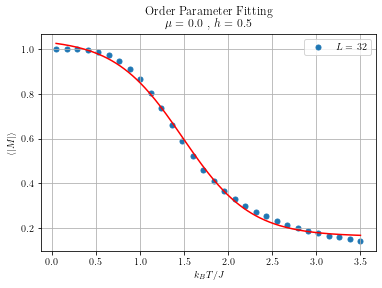

In [153]:
# Reading with pandas
filepath = 'Data/Alt'+Lidx+'_'+'Mags_'+Muidx+'_'+hidx+'.csv'
dataset = pd.read_csv(filepath)
# Interpolate using scipy
fitparams, covmat = curve_fit(\
        magsFit,dataset['Temps'],dataset['Mags'],\
        bounds=(0,[50.0,50.0,50.0,50.0]))
# Plot Interpolation and dataset
x = np.linspace(0.05,3.5,num=300)
y = magsFit(x,*fitparams)
plt.scatter(dataset['Temps'],dataset['Mags'],label=r'$L=$ '+str(Lkey[int(Lidx)]))
plt.plot(x,y,color='r')
plt.xlabel(r'$k_BT/J$')
plt.ylabel(r'$\langle |M| \rangle$')
plt.title(\
    r'Order Parameter Fitting'+'\n'+r'$\mu = $ '+str(Mukey[int(Muidx)])+' , '+r'$h = $ '+str(hkey[int(hidx)]))
plt.legend()
if save_:
    plt.savefig('Figures/'+'Fit'+Lidx+'_'+Muidx+'_'+hidx+'.pdf')
    plt.savefig('Figures/'+'Fit'+Lidx+'_'+Muidx+'_'+hidx+'.png')
plt.show()

### Finite Size Scaling

Although the non linear fit is not the best, specially for stoichiometric alloys, I believe this is the best way I can find to compromise MCMC simualtion time and precision in critical temperature computation. More in depht calculations should require use of reweighting techniques, and several dataset evaluations in order to compute mean order parameter profiles with appropriate error bars. However, due to time constraints, and a miscalculation of the time required for the analytical component of this project, I use this procedure to estimate critical temperature for an inifinite lattice.

In [207]:
# Fix fields values
Muidx = '1'
hidx = '3'
# Tag to tell program if saving plots
save_ = True

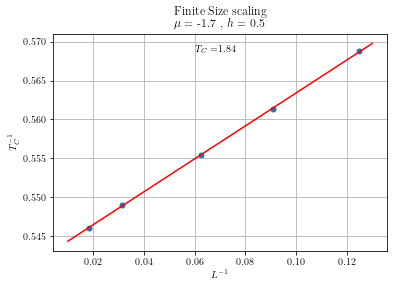

T_c =  1.8442192457749043


In [208]:
Tcs = [0,0,0,0,0]
# Reading with pandas
for Lidx in range(5):
    filepath = 'Data/Alt'+str(Lidx)+'_'+'Mags_'+Muidx+'_'+hidx+'.csv'
    dataset = pd.read_csv(filepath)
    # Eliminate first point since it was an outsider for L = 32
    m = dataset['Mags'][1:]
    T = dataset['Temps'][1:]
    # Interpolate using scipy
    fitparams, covmat = curve_fit(\
        magsFit,T,m,\
        bounds=(0,[50.0,50.0,50.0,50.0]))
    # Compute critical temperature
    Tcs[Lidx] = fitparams[2]/fitparams[3]

# Perform linear fit to find critical temperature
Bc = 1/np.array(Tcs)
Linv = 1/np.array(Lkey)
slope, intercept, _, _, _ = linregress(Linv,Bc)
Lsint = np.linspace(0.01,0.13,num=200)
Bcint = slope*Lsint + intercept

# Plot Critical Temperatures 
plt.scatter(Linv,Bc)
plt.plot(Lsint,Bcint,color='r')
plt.xlabel(r'$L^{-1}$')
plt.ylabel(r'$T_C^{-1}$')
plt.text(0.06,np.amax(Bc),r'$T_C = $'+'{:.2f}'.format(1/intercept))
plt.title(r'Finite Size scaling'+'\n'+r'$\mu = $ '+str(Mukey[int(Muidx)])+' , '+r'$h = $ '+str(hkey[int(hidx)]))
if save_:
    plt.savefig('Figures/'+'FiniteSize_'+Muidx+'_'+hidx+'.pdf')
    plt.savefig('Figures/'+'FiniteSize_'+Muidx+'_'+hidx+'.png')
plt.show()
print(r'T_c = ',1/intercept)

As can be seen in the cell above, the finite size sacling technique proposed by Ibarra siuts quite good the critical temperature dependance on lattice size. The linear fit, however is not particularly good for stoichiometric alloys, but this might be doue to the fact that the non linear fit of magnetisation profile is not particularly good for these datasets (*go to Data Interpolation*). I thus proceed to compute a table with all critical temperature data, for different values of external fields.

In [155]:
def Tcrit(muidx,hidx):
    Tcs = [0,0,0,0,0]
    # Reading with pandas
    for Lidx in range(5):
        filepath = 'Data/Alt'+str(Lidx)+'_'+'Mags_'+Muidx+'_'+hidx+'.csv'
        dataset = pd.read_csv(filepath)
        # Eliminate first point since it was an outsider for L = 32
        m = dataset['Mags'][1:]
        T = dataset['Temps'][1:]
        # Interpolate using scipy
        fitparams, covmat = curve_fit(\
            magsFit,T,m,\
            bounds=(0,[50.0,50.0,50.0,50.0]))
        # Compute critical temperature
        Tcs[Lidx] = fitparams[2]/fitparams[3]

    # Perform linear fit to find critical temperature
    Bc = 1/np.array(Tcs)
    Linv = 1/np.array(Lkey)
    slope, intercept, _, _, _ = linregress(Linv,Bc)
    return 1/intercept    

In [172]:
Muidx = '0'
save_ = False

In [173]:
Ts = []
h = []
# Compute critical temperatures
for hidx in ['0','1','2','3']:
    h.append(hkey[int(hidx)])
    Ts.append(Tcrit(Muidx,hidx))
# Create dictionary previous to dataframe
data = {
    'h':h,
    'Tcrit':Ts
       }
# Create dataframe
data = pd.DataFrame.from_dict(data)
if save_:
    filepath = 'Data/CritTemps'+Muidx+'.csv'
    data.to_csv(filepath,index=False,header=True)
# Display Critical temperatures
display(data)

,h,Tcrit
0,0.0,0.808997
1,0.1,1.083204
2,0.3,1.317169
3,0.5,1.495747


## Final Results

After performing linear regressions from finite size scaling, I obtained the following critical temperatures for $\mu = 0$:

| $h$ | $T_C$ |
|:---:|:-----:|
|$0.0$|$0.809$|
|$0.1$|$1.083$|
|$0.3$|$1.317$|
|$0.5$|$1.496$|

And the following for $\mu = -1.7$

| $h$ | $T_C$ |
|:---:|:-----:|
|$0.0$|$1.044$|
|$0.1$|$1.362$|
|$0.3$|$1.644$|
|$0.5$|$1.844$|

These are astonishing results that were not expected from mean field calculations.